In [8]:
# Imports
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

SEED = 42

In [9]:
# File path variables
# please make sure to use the correct path to the meta data file

jpgs_fp = './../data/jpgs/'
metadata_fp="./../data/HAM10000_metadata.csv"

In [10]:
# Read the metadata file
metadata = pd.read_csv(metadata_fp)

# add .jpg to the image_id column
metadata['image_id'] = metadata['image_id'].apply(lambda x: f"{x}.jpg")

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear,vidir_modern


In [11]:
# Splitting the data into train, validation and test using train_test_split

# Split the data into two subsets: train and temp (60% train, 40% temp)
train_df, temp_df = train_test_split(metadata, test_size=0.4, stratify=metadata['dx'], random_state=SEED)

# Split the temp data into validation and test sets (50% each)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'], random_state=SEED)

# resetting the index
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

display(
    train_df.shape,
    validation_df.shape,
    test_df.shape
)

(6009, 8)

(2003, 8)

(2003, 8)

In [12]:
validation_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0006879,ISIC_0029573.jpg,akiec,histo,70.0,male,lower extremity,rosendahl
1,HAM_0002621,ISIC_0028047.jpg,nv,follow_up,35.0,female,lower extremity,vidir_molemax
2,HAM_0006279,ISIC_0027195.jpg,nv,follow_up,25.0,female,neck,vidir_molemax
3,HAM_0002802,ISIC_0029717.jpg,nv,follow_up,45.0,female,abdomen,vidir_molemax
4,HAM_0005082,ISIC_0026843.jpg,bkl,histo,65.0,female,lower extremity,rosendahl


In [20]:
# Configuring an ImageDataGenerator to augment the training data

datagen_train = ImageDataGenerator(
    #rescale=1.0 / 255.0,  # Rescale pixel values to [0, 1]
    rotation_range=40,   # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,  # Randomly shift the width by up to 20%
    height_shift_range=0.2, # Randomly shift the height by up to 20%
    shear_range=0.2,     # Apply shear transformations
    zoom_range=0.2,      # Apply zoom transformations
    horizontal_flip=True, # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels with the nearest value
)

# Create an ImageDataGenerator for validation data (no augmentation)
datagen_validation = ImageDataGenerator(
    #rescale=1.0 / 255.0
)

# Using the ImageDataGenerator to load the images into memory
train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df, # using the train df created above for this generator instance
    directory=jpgs_fp,
    x_col="image_id", # column name containing the image_ids
    y_col="dx",   # column name for the labels acc to metadata file
    #subset="training",
    class_mode="categorical",
    target_size=(128, 128), 
    batch_size=32 # Important Hyperparameter: Smaller batch sizes may result in noisy gradient estimates but require less memory. Larger batch sizes can provide more stable gradients but consume more memory.
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=jpgs_fp,
    x_col="image_id",
    y_col="dx",
    #subset="validation",
    class_mode="categorical",
    target_size=(128, 128),
    batch_size=32
)

# Comments
# The above code will create two generators, one for training and one for validation and test data set
# The generators will load the images from the jpgs folder and apply the transformations specified in the ImageDataGenerator. 
# Could be transformed into a function to be used in the model

Found 6009 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


"Found 2003 validated image filenames belonging to 7 classes."
--> validated means, that the image is in the right format and can be loaded by the model from the directory and matched with an entry in the csv file

In [25]:
print(train_generator.class_indices)
print(train_generator.samples)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
6009


(32, 128, 128, 3)


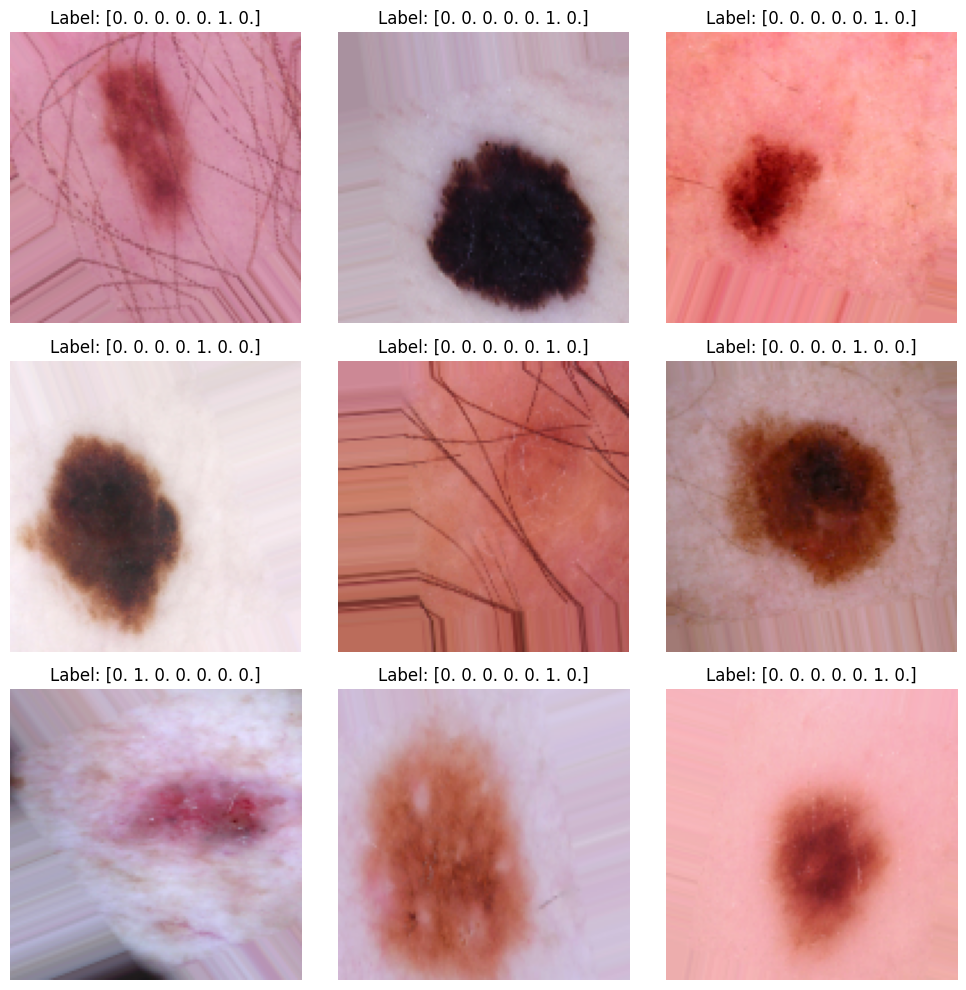

In [23]:
# Previewing the images using matplotlib

images, labels = next(train_generator)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i].astype('uint8')) 
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()